In [1]:
# personally made imports
import acquire_p
import analysis_p

# typical imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# modeling methods
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

#clean look
import warnings
warnings.filterwarnings("ignore")

get_bilancino_data()
prepare(df)


<Figure size 432x288 with 0 Axes>

# Report on Acea Smart Water Analytics
    By Jessica Gardin

## Data Dictionary

Rainfall_S_Piero    - rainfall in mm \
Rainfall_Mangona    - rainfall in mm \
Rainfall_S_Agata    - rainfall in mm \
Rainfall_Cavallina  - rainfall in mm \
Rainfall_Le_Croci   - rainfall in mm \
Temperature_Le_Croci - temperature in 'C \
Lake_Level - level in meters (m) \
Flow_Rate - flow rate in cubic meters per second (mc/s) \
avg_rain - avg of Mangona, S_Agata, Le_Croci rainfall


## Steps to reproduce

You will need a kaggle account.
https://www.kaggle.com/competitions/acea-water-prediction

Clone my repo (including the acquire_p.py)

Libraries used are pandas, matplotlib, seaborn, numpy, sklearn, datetime, math, statsmodels, and scipy.stats.


## Project Goals

Forcast water levels in Lake Bilancino to aid environmental services in determining how to handle daily consumptions efficiently.

## Project Desciption

As climate change impacts weather patterns, water may become increasingly in short supply. Learning how to predict and effecitvely manage water supplies, especially fresh water supplies, is crucial for city development and human survival. 

## Initial Testing and Hypothesis
1. Rain affects water levels in the lake
2. Temperature affects water levels in the lake
3. Flow rate out of the lake affects water levels in the lake

# Acquire
https://www.kaggle.com/competitions/acea-water-prediction/discussion/202747

Data was acquired from Kaggle in the form of a .csv file

In [2]:
lake = acquire_p.get_bilancino_data()

# Prepare
- two years of missing data was deleted

In [3]:
lake = acquire_p.prepare(lake)
lake.head()

,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
Date,,,,,,,,
2005-01-01,0.0,0.0,0.0,0.0,0.0,6.20,249.84,0.6
2005-01-02,0.0,0.0,0.0,0.0,0.0,4.55,250.63,0.6
2005-01-03,0.0,0.0,0.0,0.0,0.0,-2.00,250.72,0.6
2005-01-04,0.0,0.0,0.0,0.0,0.0,12.45,252.07,9.5
2005-01-05,0.0,0.0,0.0,0.0,0.0,20.00,252.05,6.5


# Explore/Feature Engineering

# Visual

In [4]:
example_m = analysis_p.example

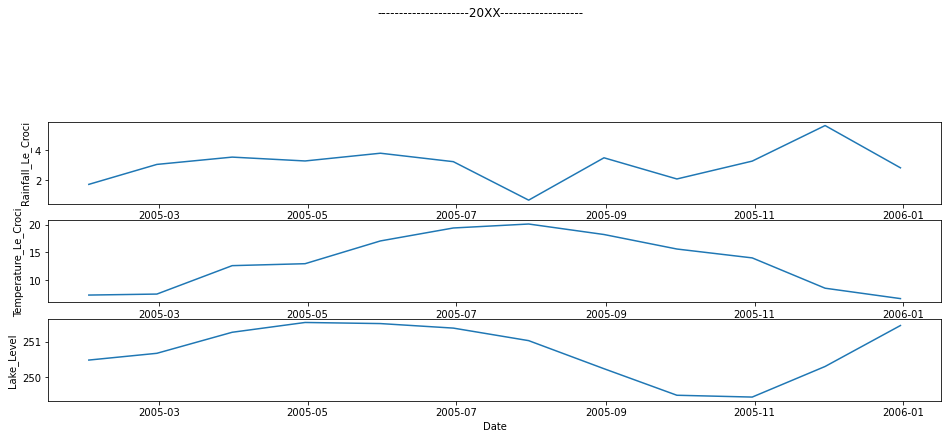

In [5]:
analysis_p.visual(example_m)

# Visual Takeaway
Data illustrates a 3 month time delay between independent variables and their effect on the Lake level. 
I chose to shift these variables by 3 months. 

# Statistical Exploration

- All continuous variables so Spearman or Pearson
- Spearman is better with monotonic patterns and skewed data set, both of which apply to this dataset

<AxesSubplot:>

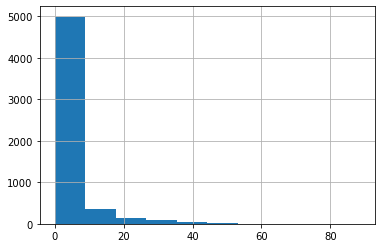

In [6]:
lake.Rainfall_Le_Croci.hist()

### No shift

In [7]:
stat_norm = analysis_p.spearmanr(lake)

### 3 Month Shift
3 months is appoximately 90 days

In [8]:
lake_3m = acquire_p.get_bilancino_data()

In [9]:
lake_3m = acquire_p.prepare(lake_3m)

In [10]:
lake_3m = analysis_p.shift90(lake_3m)

In [11]:
stat_3m = analysis_p.spearmanr(lake_3m)

# Compare Correlation Strength

In [12]:
stat_sum = stat_norm.join(stat_3m, rsuffix = '_3m')

In [13]:
stat_sum_cor = stat_sum[['correlation', 'correlation_3m']]

In [14]:
stat_sum_cor = stat_sum_cor.abs()

In [15]:
stat_sum_cor = stat_sum_cor.drop(index = ['Flow_Rate', 'Lake_Level'])

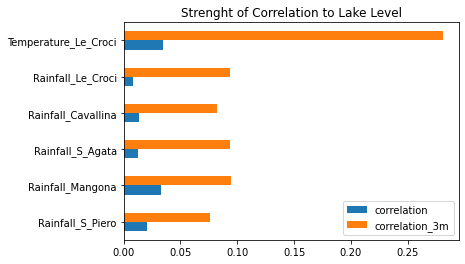

In [16]:
spear_cor = stat_sum_cor.plot(kind = 'barh', title = 'Strenght of Correlation to Lake Level')

# Compare Correlation p-value

In [17]:
stat_sum_p = stat_sum[['pvalue', 'pvalue_3m']]

In [18]:
stat_sum_p = stat_sum_p.drop(index = ['Flow_Rate', 'Lake_Level'])

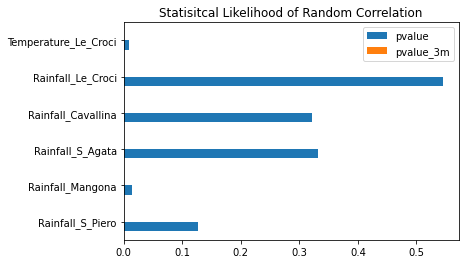

In [19]:
spear_p = stat_sum_p.plot(kind = 'barh', title = 'Statisitcal Likelihood of Random Correlation')

# Takeaway
the 3m shifted data has a stronger correlation and is most likely to actually correlate with the target variable

# Concerns for sparse matrix

In [20]:
lake.describe().round(2)

,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
count,5660.00,5660.00,5660.00,5660.00,5660.00,5660.00,5660.00,5660.00
mean,2.48,3.34,2.70,2.66,3.13,14.57,249.51,2.71
std,6.73,8.97,7.28,7.71,8.09,6.93,2.19,4.01
min,0.00,0.00,0.00,0.00,0.00,-5.35,243.53,0.45
25%,0.00,0.00,0.00,0.00,0.00,9.10,247.89,0.60
50%,0.00,0.00,0.00,0.00,0.00,14.50,250.19,1.50
75%,0.80,1.20,1.20,0.40,1.20,20.15,251.28,3.00
max,80.60,110.00,120.20,113.60,88.40,34.00,252.76,74.65


# Takeaway
based on stats testing and high amounts of zeros in data, 
I intend to comibne Rainfall Mangona, Agata, and Le_Croci

I will drop Rainfall S_Piero and Cavallina

In [21]:
lake_3m['avg_rain'] = (lake_3m.Rainfall_Mangona + lake_3m.Rainfall_S_Agata + lake_3m.Rainfall_Le_Croci)/3

In [22]:
stats_spars = analysis_p.spearmanr_a(lake_3m)

In [23]:
stats_spars = stats_spars.drop(index = ['Lake_Level'], columns = 'pvalue')

In [24]:
stats_spars = stats_spars.abs()

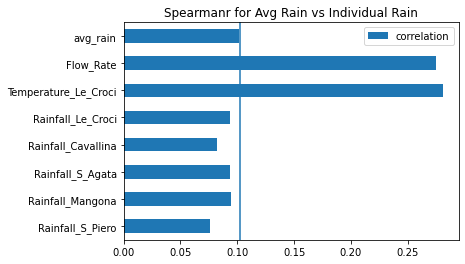

In [25]:
ax = stats_spars.plot(kind = 'barh', title = 'Spearmanr for Avg Rain vs Individual Rain')
plt.axvline(.102)

# Takeaway
avg rainfall has a stronger correlation with the target variable than any individual rain dataset

# Initial Testing and Hypothesis
1. Rain affects water levels in the lake
    - True. Specifically Le_Croci, S_Agata, and Mangona
2. Temperature affects water levels in the lake
    - True.
3. Flow rate out of the lake affects water levels in the lake
    - True.

# Model

### Split Data
16 years of data \
Human split

9 years to train (55%) \
4 years to validate (25%) \
3 years to test (20%)

In [26]:
mod_col = lake_3m.drop(columns = ['Rainfall_S_Piero', 'Rainfall_Mangona', 'Rainfall_S_Agata',
       'Rainfall_Cavallina', 'Rainfall_Le_Croci'])

In [27]:
mod_col = mod_col.resample('M').mean()

In [28]:
train = mod_col[mod_col.index < '2014-01-01']
validate = mod_col[(mod_col.index >= '2014-01-01') & (mod_col.index < '2018-01-01')]
test = mod_col[mod_col.index >= '2018-01-01']

In [29]:
trainx = train.drop(columns = 'Lake_Level')
trainy = train.Lake_Level

validatex = validate.drop(columns = 'Lake_Level')
validatey = validate.Lake_Level

testx = test.drop(columns = 'Lake_Level')
testy = test.Lake_Level

In [30]:
train.shape, validate.shape, test.shape

((105, 4), (48, 4), (36, 4))

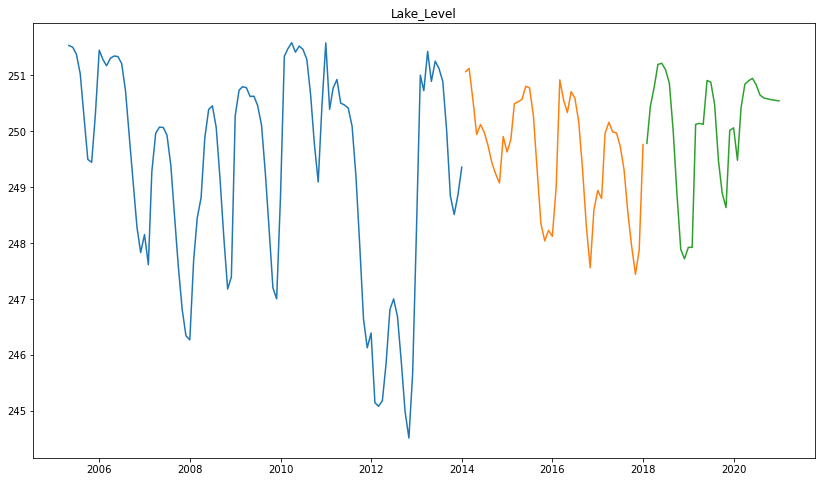

In [31]:
plt.figure(figsize=(14,8))
plt.plot(train.Lake_Level)
plt.plot(validate.Lake_Level)
plt.plot(test.Lake_Level)
plt.title("Lake_Level")
plt.show()

# Simple Avg

In [32]:
avg_train = trainy.mean()

In [33]:
yhat_df = pd.DataFrame(
    {'Lake_Level': [avg_train]},
    index=validate.index)

1.0234


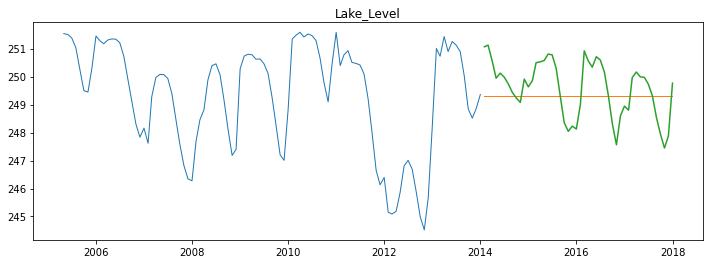

1.0234

In [34]:
analysis_p.plot_and_eval('Lake_Level', train, validate, yhat_df)

In [35]:
eval_df = analysis_p.append_eval_df(model_type = 'simple_avg', target_var = 'Lake_Level', yhat_df = yhat_df, validate = validate)

In [36]:
summary = eval_df.copy()

# Holt's Linear Trend

### FIT ONLY ON TRAIN

In [37]:
col = 'Lake_Level' 
# create our Holt's Object
model = Holt(train[col], exponential=False, damped=True)

In [38]:
# fit the holt's object
model = model.fit(optimized=True)

In [39]:
yhat = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [40]:
yhat_df = pd.DataFrame(yhat.round(2), columns = ['Lake_Level'])

1.7568


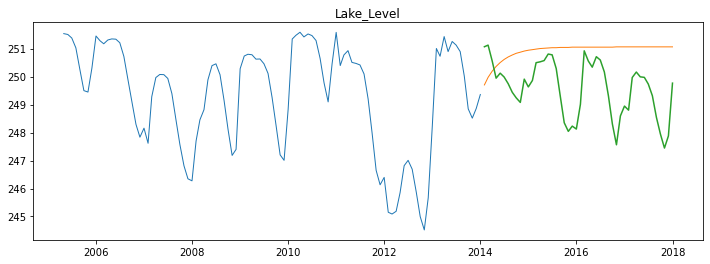

1.7568

In [41]:
analysis_p.plot_and_eval('Lake_Level', train, validate, yhat_df)

In [42]:
eval_df = analysis_p.append_eval_df(model_type = "Holt's_Linear", target_var = 'Lake_Level', yhat_df = yhat_df, validate = validate )

In [43]:
summary = pd.concat([summary, eval_df], axis =0)

# Prediction Based on Previous cycle

In [44]:
# finding the year-over-year difference for each month
# taking the mean, and then adding that value to the monthy cycle before validate series

# find yoy diff. in train data set take the mean, and add to each value in cycle before validate. 
yhat_df = trainy['2013'] + trainy.diff(12).mean()

In [45]:
# validate is 4 years

In [46]:
yhat_df = pd.concat([yhat_df,yhat_df], axis = 0)

In [47]:
yhat_df = pd.concat([yhat_df,yhat_df], axis = 0)

In [48]:
yhat_df.index = validate.index

In [49]:
yhat_df = pd.DataFrame(yhat_df.round(4), columns = ['Lake_Level'])

0.8684


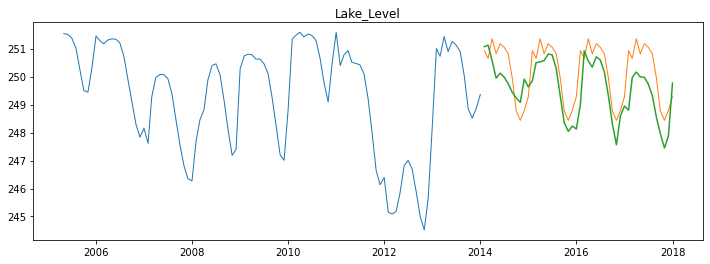

0.8684

In [50]:
analysis_p.plot_and_eval('Lake_Level', train, validate, yhat_df)

In [51]:
eval_df = analysis_p.append_eval_df(model_type = "Previouse_cycle", target_var = 'Lake_Level', yhat_df = yhat_df, validate = validate )

In [52]:
summary = pd.concat([summary, eval_df], axis =0)

# Polynomial Linear Regression

In [53]:
y1, yhat_df = analysis_p.polynomial_transform(trainx, trainy, validatex, validatey)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  1.08 
Validation/Out-of-Sample:  0.89


In [54]:
yhat_df = pd.DataFrame(yhat_df, index = validate.index, columns = ['Lake_Level'])

0.8881


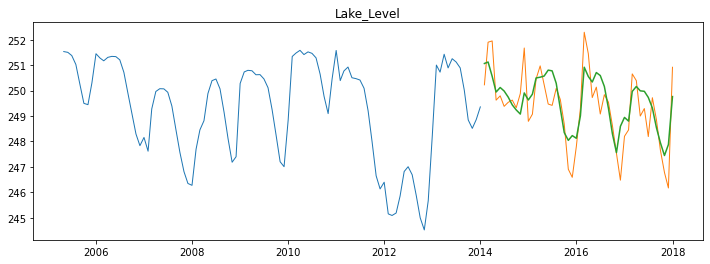

0.8881

In [55]:
analysis_p.plot_and_eval('Lake_Level', train, validate, yhat_df)

In [56]:
eval_df = analysis_p.append_eval_df(model_type = "Polynomial_Reg_deg2", target_var = 'Lake_Level', yhat_df = yhat_df, validate = validate )

In [57]:
summary = pd.concat([summary, eval_df], axis =0)

# GLM/TweedieRegressor

In [58]:
y1, yhat_df = analysis_p.glm(trainx, trainy, validatex, validatey)

RMSE for OLS using GLM
Training/In-Sample:  1.29 
Validation/Out-of-Sample:  0.68


In [59]:
yhat_df = pd.DataFrame(yhat_df, index = validate.index, columns = ['Lake_Level'])

0.6808


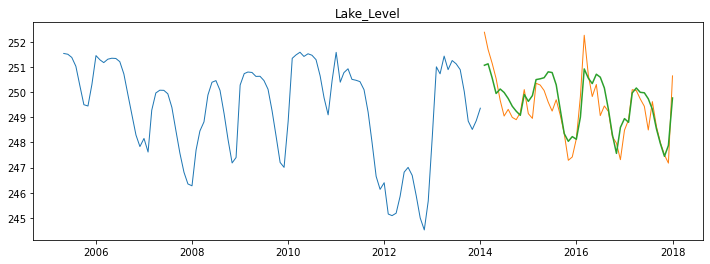

0.6808

In [60]:
analysis_p.plot_and_eval('Lake_Level', train, validate, yhat_df)

In [61]:
eval_df = analysis_p.append_eval_df(model_type = "GLM", target_var = 'Lake_Level', yhat_df = yhat_df, validate = validate)

In [62]:
summary = pd.concat([summary, eval_df], axis =0)

# Gradient Boost Regressor

In [63]:
from sklearn import ensemble
reg = ensemble.GradientBoostingRegressor()
reg.fit(trainx, trainy)

rmse = round(sqrt(mean_squared_error(validatey, reg.predict(validatex))), 4)
print("The RMSE: {:.4f}".format(rmse))

The RMSE: 0.9693


In [64]:
yhat_df = pd.DataFrame(reg.predict(validatex), columns = ['Lake_Level'])

In [65]:
yhat_df.index = validate.index

In [66]:
yhat_df = pd.DataFrame(yhat_df.round(4), columns = ['Lake_Level'])

0.9693


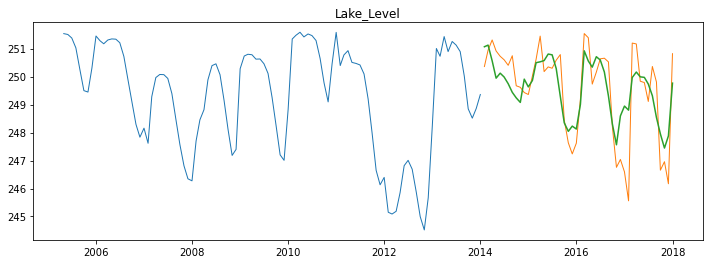

0.9693

In [67]:
analysis_p.plot_and_eval('Lake_Level', train, validate, yhat_df)

In [68]:
eval_df = analysis_p.append_eval_df(model_type = "GradientBoostingRegressor", target_var = 'Lake_Level', yhat_df = yhat_df, validate = validate )

In [69]:
summary = pd.concat([summary, eval_df], axis =0)

# RMSE Summary of Models

In [70]:
summary.set_index('model_type', inplace = True)

<AxesSubplot:ylabel='model_type'>

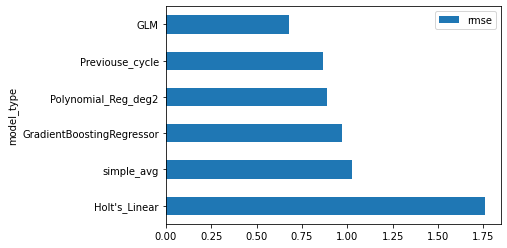

In [71]:
summary.sort_values('rmse', ascending = False).plot(kind= 'barh')

# GLM is the winner

# Test

In [72]:
y1, yhat_df = analysis_p.glm(trainx, trainy, testx, testy)

RMSE for OLS using GLM
Training/In-Sample:  1.29 
Validation/Out-of-Sample:  0.98


In [73]:
yhat_df = pd.DataFrame(yhat_df, index = test.index, columns = ['Lake_Level'])

0.9841


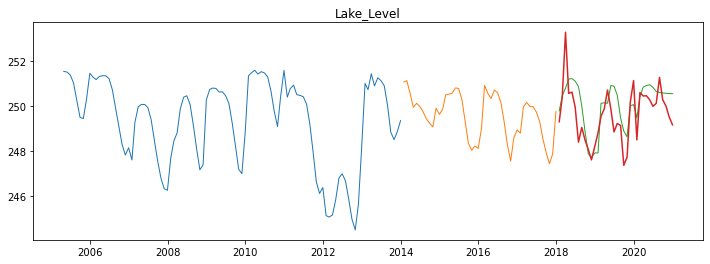

In [74]:
analysis_p.plot_and_eval_test('Lake_Level', train, validate, test, yhat_df)

# Conclusion
## Report Findings 
1. Rain affects water levels in the lake
    - True. Specifically Le_Croci, S_Agata, and Mangona
2. Temperature affects water levels in the lake
    - True.
3. Flow rate out of the lake affects water levels in the lake
    - True.

### 'GLM' was the most effective model based on RMSE scores
### Most effective feature engineering:
    - 1 M resampling period
    - 3 M shift in rainfall and temperature
    - taking avg of three most strongly correlated rainfalls: Le_Croci, S_Agata, and Mangona



##  Recommendations and Future Work

- combine model with models that predict changes in temperature and rainfall to get a more accurate

- regulate water usage to minimize use of limited water resources

- invest in salt-water conversion to fresh water
